<a href="https://colab.research.google.com/github/AmiraFaisal/Scenario2/blob/main/Scenario_2_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[google doc](https://docs.google.com/document/d/1AJEu1s_ViChkY-IaLYIUC7Ia_XehJ62D9Er2ykEBsMs/edit?usp=drive_link)

In [ ]:
import torch, sys, os
print("python:", sys.executable)
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("torch.backends.cudnn.enabled:", torch.backends.cudnn.enabled)
print("cuda available:", torch.cuda.is_available())
print("cuda devices visible:", os.environ.get("CUDA_VISIBLE_DEVICES"))

python: /usr/bin/python3
torch.__version__: 2.9.0+cu126
torch.version.cuda: 12.6
torch.backends.cudnn.enabled: True
cuda available: True
cuda devices visible: None


# **1. Data Exploration and Preprocessing**

## **a. Load and explore**
the MedQuAD dataset to understand its structure and content.

### Set up libraries, dataset

In [ ]:
pip install wordcloud matplotlib --quiet

In [ ]:
pip install langchain --quiet

In [ ]:
pip install langchain-text-splitters --quiet

In [ ]:
pip install -q datasets sentence-transformers faiss-cpu transformers accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.8 MB/s eta 0:00:00


In [ ]:
pip install chromadb --quiet

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint
import chromadb
import torch
import random


In [ ]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from langchain_text_splitters import RecursiveCharacterTextSplitter
from hashlib import md5
from datasets import Dataset, DatasetDict
from transformers import(
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer)

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

In [ ]:
url = "https://raw.githubusercontent.com/AmiraFaisal/Scenario2/main/MedQuAD_Dataset_RAG_Scenario_2.csv"
df = pd.read_csv(url, header = 0)
df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


### Perform basic exploratory data analysis




including the
distribution of medical topics or question types, the average length of
questions and answers, and the presence of metadata.

Include suitable
forms of visualisation in your report, generated from your code, to
illustrate key characteristics of the dataset.

To keep runtime
manageable in Colab, you may work with a representative subset of
the dataset (for example, select a few high-frequency focus_area
categories).

If you decide to do so, you need to clearly describe any
subsampling in your report.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


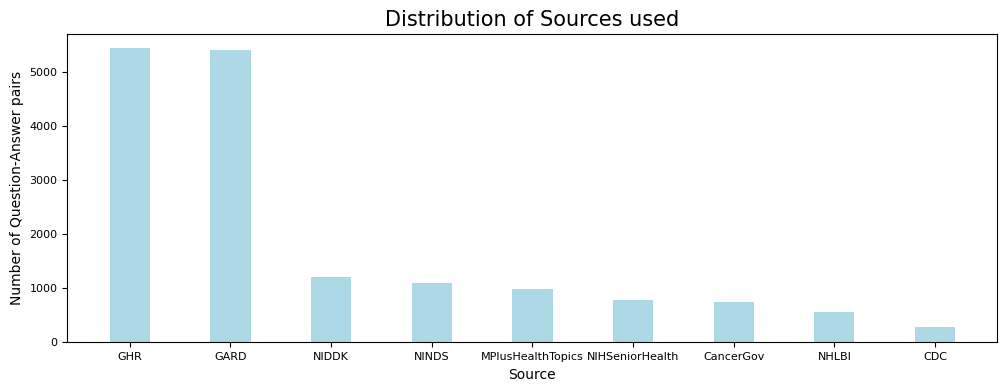

9 Sources used:  ['CDC', 'CancerGov', 'GARD', 'GHR', 'MPlusHealthTopics', 'NHLBI', 'NIDDK', 'NIHSeniorHealth', 'NINDS']


In [ ]:
# Bar Chart
source_counts = df['source'].value_counts()

plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 8})
plt.bar(source_counts.index, source_counts.values, color='lightblue', width=0.4)
plt.xlabel("Source", fontsize=10)
plt.ylabel("Number of Question-Answer pairs", fontsize=10)
plt.title("Distribution of Sources used", fontsize=15)
plt.show()

# Unique 'source's
unique_sources = df['source'].unique()
print(len(unique_sources), "Sources used: ", sorted(unique_sources))

In [ ]:
# Unique 'focus_area's or Medical Topics
unique_focus_areas = df['focus_area'].astype(str).unique()
print(len(unique_focus_areas), "unique Focus Areas")

5127 unique Focus Areas


### Downsampling `focus_area`

In [ ]:
focus_area_counts = df['focus_area'].value_counts()

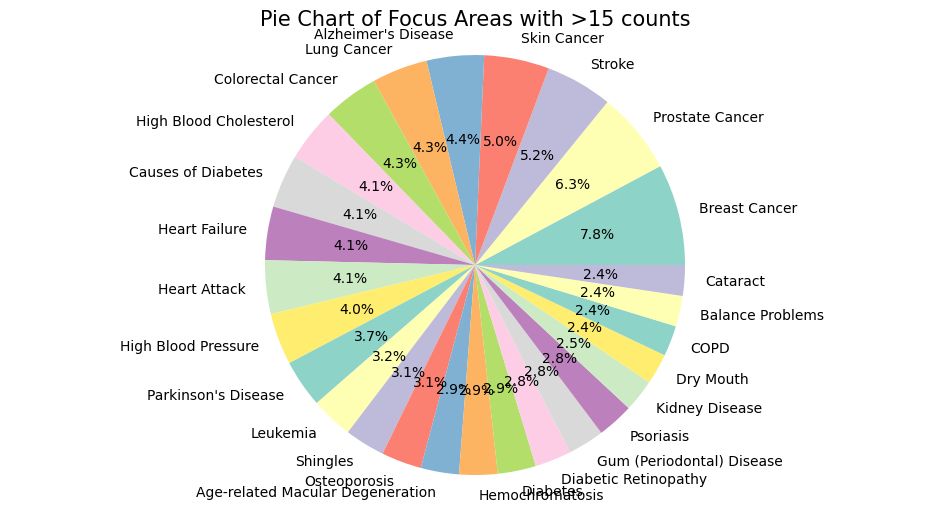

In [ ]:
# Pie chart of Focus areas with >15 counts
above15counts = focus_area_counts[focus_area_counts > 15] .index
filtered =focus_area_counts[above15counts]

plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize = (12,6))

colors = plt.get_cmap('Set3').colors
ax.pie(filtered, labels = above15counts, autopct = '%1.1f%%', colors = colors)
ax.set_title("Pie Chart of Focus Areas with >15 counts", fontsize = 15)
ax.axis('equal')
plt.show()

In [ ]:
# Table summary of Focus area distribution
groups = pd.cut(focus_area_counts,
                bins = [0, 4, 20, float('inf')],
                labels = ['<5', '5 - 20', '>20'])
summary_focus_area = groups.value_counts().sort_index().to_frame(name = 'focus_area')
summary_focus_area['%'] = (summary_focus_area['focus_area'] / summary_focus_area['focus_area'].sum()) * 100
summary_focus_area['%'] = summary_focus_area['%'].map('{:.1f}%'. format)
summary_focus_area

,focus_area,%
count,,
<5,3388,66.1%
5 - 20,1722,33.6%
>20,16,0.3%


In [ ]:
# Only use counts >10 and then top 1000 focus areas
above10counts_index = focus_area_counts[focus_area_counts > 10].index
above10counts = focus_area_counts[above10counts_index]
top1000 = above10counts.head(1000)

# cap at max 20 counts per focus area
new = pd.DataFrame()
for f_a in top1000.index:
    fa_df = df[df['focus_area'] == f_a]
    sample = fa_df.sample(n = min(20, len(fa_df)))
    new = pd.concat([new, sample])

print("Original df shape:", df.shape)
print("After cleaning   :", new.shape)

Original df shape: (16412, 4)
After cleaning   : (1427, 4)


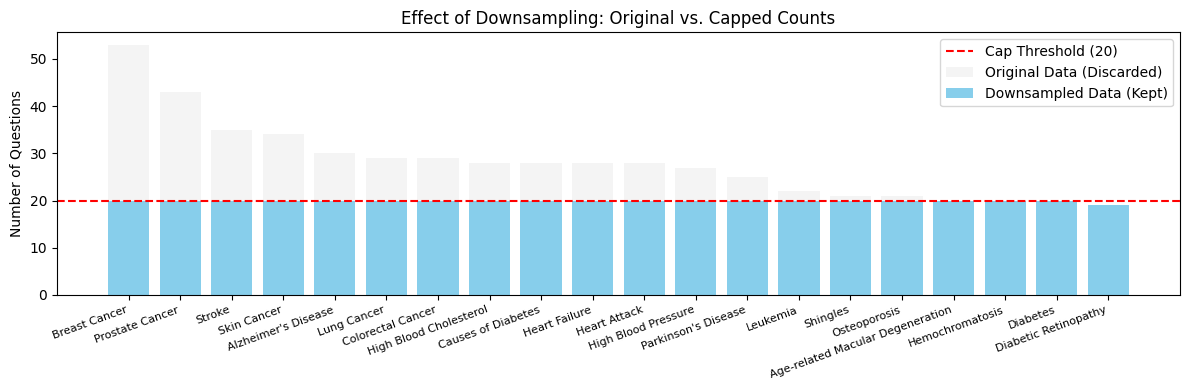

In [ ]:
sampled_counts = new['focus_area'].value_counts()

# Select top 20 focus areas from the ORIGINAL data to visualize
top_areas = focus_area_counts.head(20).index

# Align both datasets to these top 20
original_vals = focus_area_counts.loc[top_areas]
sampled_vals = sampled_counts.reindex(top_areas, fill_value=0)

plt.figure(figsize=(12, 4))

# Plot Original Data (The "Shadow")
plt.bar(top_areas, original_vals, color='gainsboro', alpha=0.3, label='Original Data (Discarded)')

# Plot Sampled Data (The "Result")
plt.bar(top_areas, sampled_vals, color='skyblue', alpha=1.0, label='Downsampled Data (Kept)')

plt.axhline(y=20, color='red', linestyle='--', label='Cap Threshold (20)')

plt.xticks(rotation=20, ha = 'right', fontsize = 8)
plt.title('Effect of Downsampling: Original vs. Capped Counts')
plt.ylabel('Number of Questions')
plt.legend()
plt.tight_layout()
plt.show()

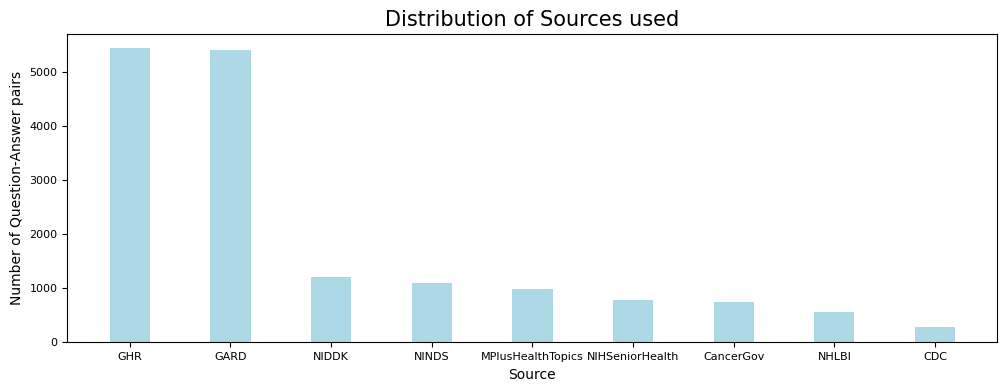

9 Sources used:  ['CDC', 'CancerGov', 'GARD', 'GHR', 'MPlusHealthTopics', 'NHLBI', 'NIDDK', 'NIHSeniorHealth', 'NINDS']


In [ ]:
# Bar Chart
source_counts = df['source'].value_counts()

plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 8})
plt.bar(source_counts.index, source_counts.values, color='lightblue', width=0.4)
plt.xlabel("Source", fontsize=10)
plt.ylabel("Number of Question-Answer pairs", fontsize=10)
plt.title("Distribution of Sources used", fontsize=15)
plt.show()

# Unique 'source's
unique_sources = df['source'].unique()
print(len(unique_sources), "Sources used: ", sorted(unique_sources))

NIHSeniorHealth is majority, so assume **audience for QA is the elderly**, as stated on their website, "NIA provides health information informed by research and reviewed by experts to help you learn about healthy aging and common health conditions in older adults."

In [ ]:
df = new.copy()

### Length Distributions, QA relation, WordCloud

In [ ]:
word_count_question = df['question'].apply(lambda x: len(x.split(' ')) + 1)
word_count_answer = df['answer'].apply(lambda x: len(str(x).split(' ')) + 1)

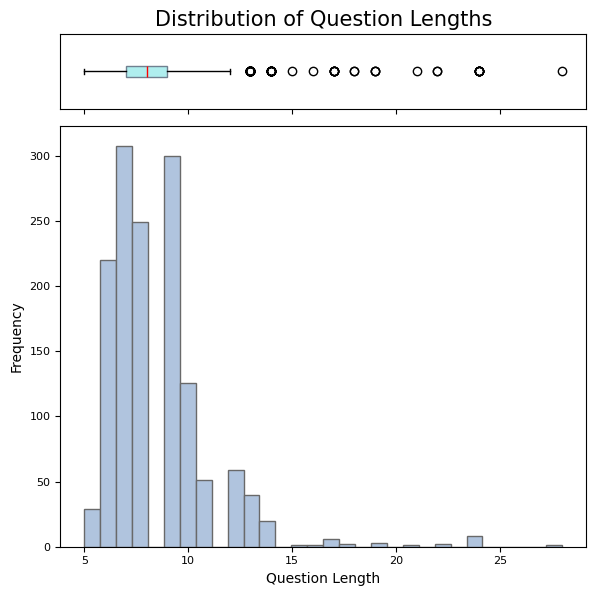

In [ ]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))
# Box plot
ax_box.boxplot(word_count_question, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Question Lengths', fontsize=15)

# Histogram on the bottom subplot
ax_hist.hist(word_count_question, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Question Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

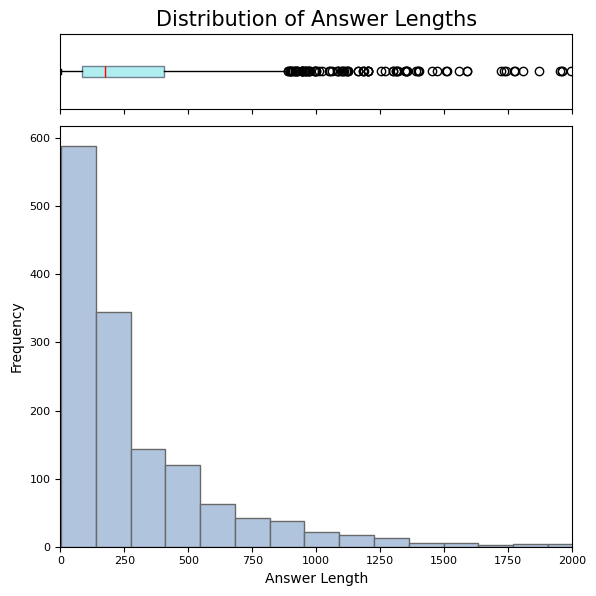

In [ ]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))
# Box plot
ax_box.boxplot(word_count_answer, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Answer Lengths', fontsize=15)

# Histogram on the bottom subplot
ax_hist.hist(word_count_answer, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Answer Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

ax_hist.set_xlim(0,2000)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

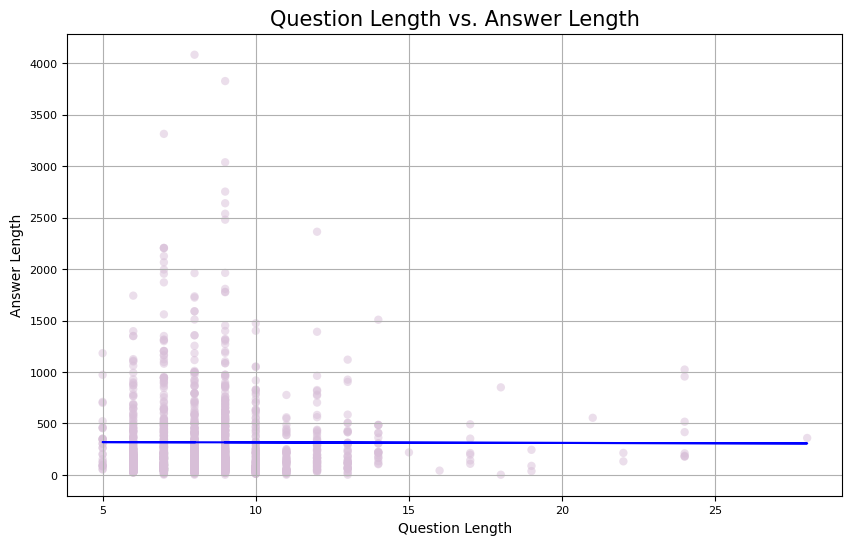

The gradient of the straight line is: -0.5378


In [ ]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(word_count_question, word_count_answer, alpha=0.5, edgecolors='none', color='thistle')

# Calculate equation for trendline
z = np.polyfit(word_count_question, word_count_answer, 1)
p = np.poly1d(z)
ax.plot(word_count_question, p(word_count_question), color='blue')

ax.set_xlabel('Question Length', fontsize=10)
ax.set_ylabel('Answer Length', fontsize=10)
ax.set_title('Question Length vs. Answer Length', fontsize=15)

ax.grid(True)
plt.show()

z = np.polyfit(word_count_question, word_count_answer, 1)
print(f"The gradient of the straight line is: {z[0]:.4f}")

Every 1-word increase in *Question length*, increases *Answer length* by ~6.48 words.

Question key words reveal a trend on chronic diseases or major health conditions (e.g. x, y, z)

Most questions seek definitions to medical conditions, as well as asking the cause or symptoms. Consequently, there is strong interest in treatment information.

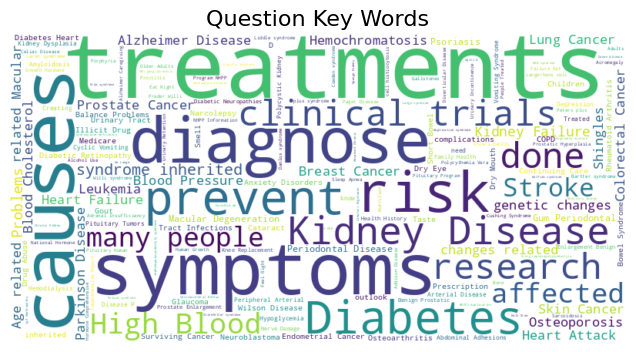

In [ ]:
question_text = ' '.join(df['question'].astype(str))
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      colormap='viridis').generate(question_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide axes
plt.title("Question Key Words", fontsize=16)
plt.show()

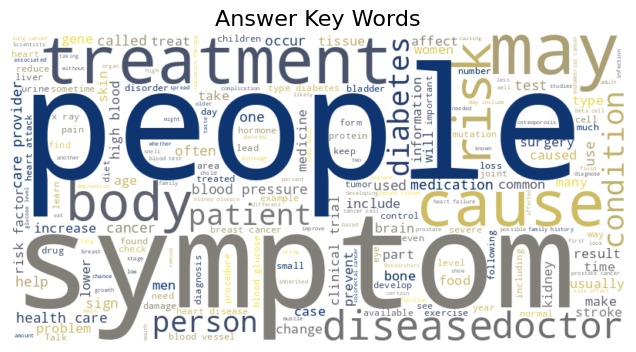

In [ ]:
question_text = ' '.join(df['answer'].astype(str))
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      colormap='cividis').generate(question_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide axes
plt.title("Answer Key Words", fontsize=16)
plt.show()

## **b. Prepare the data**



### Duplicates - part 1

Set up needed functions

In [ ]:
def normalize_text(text):
    """
    Aggressive normalization for duplicate detection.
    Removes all extra spaces, punctuation variations, etc.
    """
    if not isinstance(text, str): return ""

    text = text.lower() # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove all extra whitespace (spaces, tabs, newlines)
    text = text.strip() # Remove leading/trailing spaces

    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

def hashing(df):
    """Create hash for Q&A pairs to detect duplicates.
       Returns: DataFrame with new 'qa_hash' column
    """
    # Normalize for Q and A fields using earlier 'normalize_text' function
    q_norm = df['question'].apply(normalize_text)
    a_norm = df['answer'].apply(normalize_text)

    # Combine normalized Q&A
    qa_norm = q_norm + '|||' + a_norm

    # Create 16 digit hash
    df['qa_hash'] = qa_norm.apply(lambda x: md5(x.encode()).hexdigest())

    return df

def identify_duplicates(df):
    """Search for same hashes and report back
       Returns: Index of duplicate hashes, d_df
    """
    qa_hash = df['qa_hash']

    # Find which hashes appear more than once
    hash_counts = qa_hash.value_counts()
    d_hashes = hash_counts[hash_counts > 1].index

    print(f"Of {len(df)} pairs, {qa_hash.nunique()} unique hashes were created")
    print(f"Duplicate groups found: {len(d_hashes)}")
    print(f"Total duplicate pairs: {hash_counts[d_hashes].sum()}")

    # Create d_df to store duplicated pairs
    d_df = df[qa_hash.isin(d_hashes)].copy()

    # Group duplicates using ids
    hash_groups = {hash_val: i for i, hash_val in enumerate(d_hashes)}
    d_df['duplicate group'] = d_df['qa_hash'].map(hash_groups)
    d_df = d_df.sort_values('duplicate group')

    return d_hashes, d_df

def remove_duplicates(df):
    """
    Returns: clean_df, d_df
    """
    d_hashes, d_df = identify_duplicates(df)

    # Remove duplicates
    clean_df = df.drop_duplicates(subset = 'qa_hash', keep = 'first').copy()

    # Remove temporary fields
    clean_df = clean_df.drop(['qa_hash'], axis=1)
    d_df = d_df.drop(['qa_hash'], axis=1)

    print(f"After removing duplicates: {len(clean_df)} pairs")
    print(f"Removed: {len(df) - len(clean_df)} pairs\n")

    return clean_df, d_df

def truncate(text, length_limit):
    """Truncate text to `length_limit` characters."""
    return f"{text[:length_limit]}{'...' if len(text) > length_limit else ''}"

def show_duplicates(df, max_groups = 10):
    """Show grouped duplicates
    """
    clean_df, d_df = remove_duplicates(df)

    if d_df is None:
        print("No duplicates found")
        return
    d_groups = d_df.groupby('duplicate group')
    print(f"{' '*21} Showing {max_groups} duplicate groups")
    d_pairs = list(d_groups)[:max_groups]
    for i, g in d_pairs:
        print(f"{'='*70}")
        print(f"{' '*22} GROUP {i+1} with {len(g)} occurrences")
        print(f"{'='*70}")

        p_ids = []
        for index, (pair_idx, pair) in enumerate(g.iterrows(),1):
            p_ids.append(f"Row {pair_idx}")
        print(", ". join(p_ids))

        pair = g.iloc[0]
        print("The duplicated QA pair")
        print(f"    Question: {truncate(pair['question'], 100)}")
        print(f"    Answer  : {truncate(pair['answer'], 60)}")
        print(f"    Focus Area: {pair['focus_area']}")

### Duplicates - part 2

duplicates in answer field

In [ ]:
# Hash Q&A pairs
df = hashing(df)

# Review found duplicates
show_duplicates(df, max_groups = 10)

Of 1427 pairs, 1398 unique hashes were created
Duplicate groups found: 21
Total duplicate pairs: 50
After removing duplicates: 1398 pairs
Removed: 29 pairs

                      Showing 10 duplicate groups
                       GROUP 1 with 7 occurrences
Row 16019, Row 15247, Row 15248, Row 16209, Row 15346, Row 16020, Row 15347
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Other types of diabetes have a variety of possible causes.
 ...
    Focus Area: Causes of Diabetes
                       GROUP 2 with 3 occurrences
Row 15343, Row 16016, Row 15244
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Type 1 diabetes is caused by a lack of insulin due to the de...
    Focus Area: Causes of Diabetes
                       GROUP 3 with 3 occurrences
Row 16021, Row 16211, Row 15348
The duplicated QA pair
    Question: What to do for Causes of Diabetes ?
    Answer  : - Diabetes is a complex group of diseases with a v

In [ ]:
# Remove duplicates
clean_df, d_df = remove_duplicates(df)

Of 1427 pairs, 1398 unique hashes were created
Duplicate groups found: 21
Total duplicate pairs: 50
After removing duplicates: 1398 pairs
Removed: 29 pairs



In [ ]:
df = clean_df

One of the primary advantages of using cryptographic hashing in data deduplication is its ability to quickly determine unique data segments. By generating a hash for each piece of data, systems can compare hash values rather than the actual data. If two data segments produce the same hash, they can be identified as duplicates. This method significantly reduces the time and resources required for data comparison, as comparing hash values is computationally less intensive than comparing full data sets.

### Clean `answer` field

In [ ]:
import re

def clean_references(text):

    if not isinstance(text, str):
        return ""

    # lowercasing
    text = text.lower()

    phone_pattern = r'\b\d{3}-\d{3}-\d{4}\b|\b\d{3}-\d{2}-\d{4}\b|\b1-\d{3}-\d{3}-\d{4}\b|\b\d{4}-\d{3}-\d{4}\b|\bToll Free:.*?\b'
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    address_pattern = r'\d+\s+[A-Za-z\s]+,\s*[A-Za-z\s]+,\s*[A-Z]{2}\s*\d{5}(-\d{4})?'

    # remove patterns
    text = re.sub(phone_pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(email_pattern, '', text)
    text = re.sub(url_pattern, '', text)
    text = re.sub(address_pattern, '', text)

    ref_keywords = ['toll free', 'phone', 'email', 'fax', 'tty', 'clearinghouse', 'esc', 'keyboard', 'video','for more information', 'glossary']

    # Split by sentence-ending punctuation followed by space
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # if sentence has no ref_keywords, then save to cleaned_sentences
    cleaned_sentences = [s for s in sentences if not any(keyword in s.lower() for keyword in ref_keywords)]
    cleaned_text = '.'.join(cleaned_sentences).strip()

    # remove trailing/ leading punctuation or spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = re.sub(r'^\s*\.\s*', ' ', cleaned_text)
    return cleaned_text

df_answer = df['answer'].apply(clean_references)

In [ ]:
print("Before: ", df['answer'][0])
print("After: ", df_answer[0])
df['answer'] = df_answer

Before:  Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the pressure inside the eye rises. Unless this pressure is controlled, it may cause damage to the optic nerve and other parts of the eye and result in loss of vision. Open-angle Glaucoma The most common type of gl

### Split datasets

to be then train and validate the LLM

In [ ]:
train_data, testval = train_test_split(
    df,
    test_size = 0.40, # 40% for test + val
    stratify = df['focus_area'],
    random_state = 1)

val_data, test_data = train_test_split(
    testval,
    test_size = 0.50, # split the remaining 40% equally
    stratify =  testval['focus_area'],
    random_state = 1)

print("Training data shape  : ", train_data.shape)
print("Validation data shape: ", val_data.shape)
print("Test data shape      : ", test_data.shape)

Training data shape  :  (838, 4)
Validation data shape:  (280, 4)
Test data shape      :  (280, 4)


### Create chunks

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)

all_chunks = []
for i, row in df.iterrows():
    q, a, focus, source = row['question'], row['answer'], row['focus_area'], row['source']
    chunks = text_splitter.split_text(a)

    for chunk_id, chunk in enumerate(chunks):
        all_chunks.append({
            'question_id': i,                 # Original Row ID
            'chunk_id': f"{i}_{chunk_id}", # Unique ID of specific chunk (e.g., 0_1, 0_2)
            'question': q,                    # Original question
            'chunk_answer': chunk,       # The actual split text
            'focus_area': focus
        })


In [ ]:
pprint.pprint(all_chunks[0], sort_dicts=False)
pprint.pprint(all_chunks[1], sort_dicts=False)

{'question_id': 771,
 'chunk_id': '771_0',
 'question': 'What are the symptoms of Breast Cancer ?',
 'chunk_answer': 'signs of breast cancer include a lump or change in the '
                 'breast..these and other signs may be caused by breast cancer '
                 'or by other conditions..check with your doctor if you have '
                 'any of the following: - a lump or thickening in or near the '
                 'breast or in the underarm area..- a change in the size or '
                 'shape of the breast..- a dimple or puckering in the skin of '
                 'the breast..- a nipple turned inward into the breast..- '
                 'fluid, other than breast milk, from the nipple, especially '
                 "if it's bloody..- scaly, red, or",
 'focus_area': 'Breast Cancer'}
{'question_id': 771,
 'chunk_id': '771_1',
 'question': 'What are the symptoms of Breast Cancer ?',
 'chunk_answer': "especially if it's bloody..- scaly, red, or swollen skin on "
       

### Create dense vector embeddings

convert each chunk into dense vector embeddings using `SentenceTransformer` model

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
chunk = [c['chunk_answer'] for c in all_chunks]
embeddings = embed_model.encode(
    chunk,
    batch_size = 64,
    show_progress_bar = True,
    convert_to_numpy = True,
    normalize_embeddings = True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/84 [00:00<?, ?it/s]

### Build FAISS index for similarity search

(for example, using a vector store or another suitable retrieval approach).

`indices` means positions of documents that are similar to the user query

`distances` means the simialrity scores of these documents

In [ ]:
import faiss

In [ ]:
dim = embeddings.shape[1]
index  = faiss.IndexFlatIP(dim)
index.add(embeddings)

In [ ]:
print("Embeddings shape: ", embeddings.shape[0])
print("Index Size      : ", index.ntotal)

Embeddings shape:  5324
Index Size      :  5324


### Chromadb vector store

In [ ]:
len(all_chunks)

5324

In [ ]:
db_client = chromadb.PersistentClient(path="./MedQuAD_db")

try: # in case of duplicates from re-runs
    db_client.delete_collection("medical_rag")
except:
    pass

# Create collection
collection = db_client.create_collection(name="medical_rag")


# Create specific lists for Chroma
# 1. Get just the text for the "documents" field
doc_texts = [item['chunk_answer'] for item in all_chunks]

# 2. Get the rest of the info for the "metadatas" field
# Chroma requires metadata values to be strings, ints, or floats (no lists/dicts inside)
meta_list = []
for item in all_chunks:
    meta_list.append({
        "question": item['question'],
        "focus_area": item.get('focus_area', 'General') # Use .get() in case it's missing
    })

print("Adding data to ChromaDB...")
collection.add(
    ids=[str(i) for i in range(len(embeddings))],
    embeddings=embeddings.tolist(),
    documents=doc_texts,      # <--- Now this is a list of Strings (FIXED)
    metadatas=meta_list       # <--- The other info goes here
)

Adding data to ChromaDB...


# **2. Implement a Retrieval-Augmented Generation (RAG):**

Uses a Retriever to embed and retrieve relevant document chunks,
and a Generator, which is a pretrained language model instructed to
answer based only on retrieved context.

## **Retriever**

**Retriever**: Responsible for finding relevant documents or passages from a knowledge base given a query.

### Rewrite query

Below is an instruction that describes a task, paired with an inpu that provides further context. Write a response that appropriately completes the request. Instruction: {You are a helpful medical practitioner}
Input:
{}
Response:
{}

In [ ]:
llm = pipeline(
    "text2text-generation",
    model="google/flan-t5-small",
    max_length=128,
    do_sample=True,
    temperature=0.3,
    repetition_penalty=1.3,
    no_repeat_ngram_size=2
)

def rewrite_query(user_query):
    """ Rewrite the user query to be more specific, medical focused.
    Return rewritten query"""

    # few shot prompting
    prompt = f"""
    Rewrite Output 4 questions to be specific medical search queries.
    Input: my head hurts
    Output: What are the primary causes of headaches and severe migraines?

    Input: sugar levels too high
    Output: What are the clinical symptoms and management strategies for hyperglycemia?

    Input: is drug X safe for kids
    Output: What are the pediatric contraindications and safety guidelines for Drug X?

    Input: heart beating too fast
    Output: What are the differential diagnoses for tachycardia and heart palpitations?

    Input: {user_query}
    Output 4:
    """

    llm_output = llm(prompt)

    rewritten_query = llm_output[0]['generated_text']
    rewritten_query = rewritten_query.replace("Output:", "").strip()

    return rewritten_query.strip()

Device set to use cuda:0


In [ ]:
user_query = "How to diagnose Paget's Disease of Bone ?"
rewritten_query = rewrite_query(user_query)

print(f"Original: {user_query}")
print(f"Rewritten: {rewritten_query}")

Original: How to diagnose Paget's Disease of Bone ?
Rewritten: What are the symptoms of Paget's Disease of Bone?


### Re-rank Contexts

In [ ]:
rerank_tokenizer = AutoTokenizer.from_pretrained("castorini/monot5-base-msmarco")
rerank_model = AutoModelForSeq2SeqLM.from_pretrained("castorini/monot5-base-msmarco")
rerank_model.eval() # Set to evaluation mode, w/o training

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
def getMonoT5Scores(query, chunks):
  """Calculate relevance scores aginst query
  Returns list of scores
  """
  inputs = [f"Query: {query} Document: {c} Relevant:" for c in chunks]
  tokenized_inputs = rerank_tokenizer(
      inputs,
      padding = True,
      truncation = True,
      return_tensors = 'pt')
  with torch.no_grad():
    outputs = rerank_model.generate(
        input_ids=tokenized_inputs['input_ids'],
        attention_mask=tokenized_inputs['attention_mask'],
        max_new_tokens = 1,
        return_dict_in_generate = True,
        output_scores = True
    )

    # Get scores of token "True"
    true_token_id = rerank_tokenizer.encode("true")[0]
    batch_scores = outputs.scores[0][:, true_token_id]

    return batch_scores.tolist()

In [ ]:
def retriever(q, top_k = 5, detail = False):
    """Retrieve context based on user query
    Returns contexts"""

    # 1. Embed the rewritten query
    q = rewrite_query(q)
    q_embed = embed_model.encode([q]).tolist() # .tolist() because Chroma expects lists, not numpy arrays

    # 2. Search for similar vectors in chromadb collection
    search_result = collection.query(
        query_embeddings = q_embed,
        n_results = 10)

    # 3. Format search results
    retrieved_chunks = search_result['documents'][0]
    retrieved_metas = search_result['metadatas'][0]
    retrieved_distances = search_result['distances'][0] if 'distances' in search_result else [0] * len(retrieved_chunks)

    # 4. Rerank
    rerank_scores = getMonoT5Scores(q, retrieved_chunks)

    # 5. Map score with their data
    candidates = []
    for r in range(len(retrieved_chunks)):
      candidates.append({
        'chunk_answer': retrieved_chunks[r],
        'question': retrieved_metas[r]['question'],
        'focus_area': retrieved_metas[r]['focus_area'],
        'chroma_dist': retrieved_distances[r],
        'rerank_score': rerank_scores[r]
      })

    # 6. Sort high to low scores
    candidates.sort(key = lambda s:s['rerank_score'], reverse = True)
    sorted_results = candidates[:top_k]

    # 7. Combine needed items into `contexts` dictionary
    contexts = []
    for i in sorted_results:
        item = {'chunk_answer': i['chunk_answer'],
                'question': i['question']}
        if detail:
            item['focus_area'] = i['focus_area']
            item['similarity_score'] = round(i['rerank_score'], 3)
        contexts.append(item)

    return contexts

## **Augmenter**

### Fine-tuning `google/flan-t5-small`

Tokenize *i.e. segment the `train` and `val` text into subwords or tokens, which the model then utilizes as input.*

In [ ]:
# --- load model
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
# --- Convert pandas DataFrame to Huggin Face Dataset object first
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)

In [ ]:
def tokenise(examples):
    """Create strings, and Tokenize both train_data & val_data
       Return: model_inputs"""

    # Create input and target strings
    inputs =[]
    for fa, q in zip(examples['focus_area'], examples['question']):
        text = "Focus: " + fa + " Question: " + q
        inputs.append(text)
    targets = examples['answer']

    # Tokenize inputs (questions + focus areas)
    model_inputs = tokenizer(
        inputs,
        max_length = 128,
        padding = False,
        truncation = True)

    # Tokenize targets (answers)
    model_labels = tokenizer(
        targets,
        max_length = 512,
        padding = False,
        truncation = True)

    model_inputs["labels"] = model_labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_train = train_ds.map(tokenise, batched = True)
tokenized_val = val_ds.map(tokenise, batched = True)

Map:   0%|          | 0/838 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [ ]:
collator = DataCollatorForSeq2Seq(
    tokenizer = tokenizer,
    model = model,
    label_pad_token_id = -100, # model wont be pernalised for empty spaces
    pad_to_multiple_of = 8) # Pads sequences to the same length

In [ ]:
training_args = Seq2SeqTrainingArguments( ## NOT RUN YET
    output_dir="./fine-tuned-Flan-T5-small",

    # --- The "Big Three" (Hyperparameters) ---
    learning_rate = 2e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 10,

    # --- Weight Decay (Prevents overfitting) ---
    weight_decay = 0.01,

    # --- THE KEY CHANGES (Fixing the Error) ---
    eval_strategy = "epoch",              # Chang
    load_best_model_at_end = True,        # Added this
    metric_for_best_model = "loss",       # Added this

    # --- "Housekeeping" (Saving & Logging) ---
    save_strategy = "epoch",
    logging_steps = 50,
    save_total_limit = 2,
    report_to = 'tensorboard',

    # --- T5 Specifics ---
    predict_with_generate = True,
    fp16 = False,                          # Still True in this version
)

In [ ]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience = 3,
    early_stopping_threshold = 0.001
)

In [ ]:
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    data_collator = collator,
    processing_class = tokenizer,
    callbacks = [early_stopping]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.895700,2.516006
2,2.727500,2.442389
3,2.591900,2.391764
4,2.539500,2.360396
5,2.487300,2.335876
6,2.452200,2.316901
7,2.383200,2.304479
8,2.359900,2.298737
9,2.335800,2.293997
10,2.335400,2.292125


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=1050, training_loss=2.515188257126581, metrics={'train_runtime': 652.4754, 'train_samples_per_second': 12.843, 'train_steps_per_second': 1.609, 'total_flos': 123164077522944.0, 'train_loss': 2.515188257126581, 'epoch': 10.0})

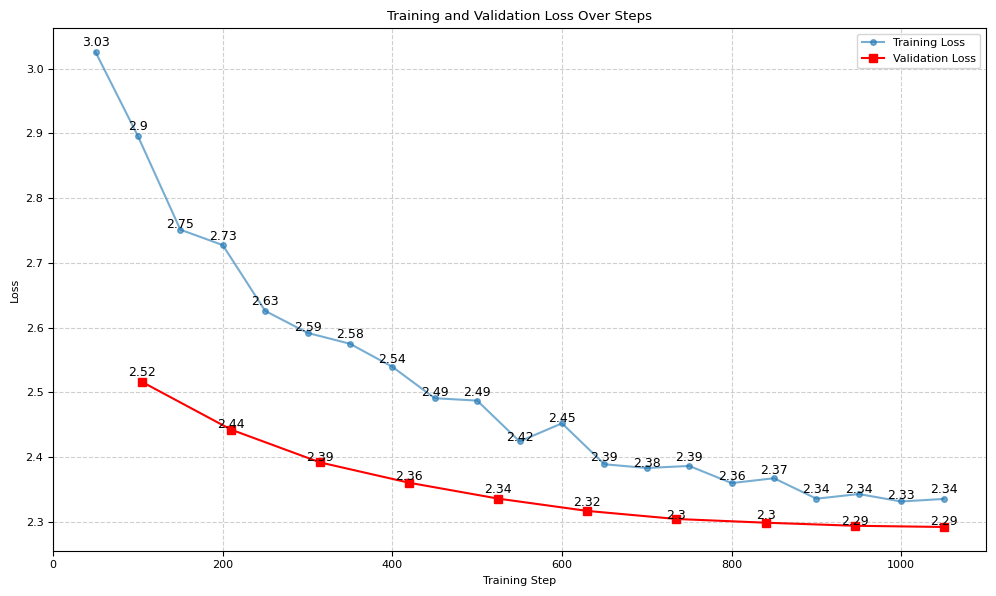

In [ ]:
# --- Plot training & validation loss curves
log_history_df = pd.DataFrame(trainer.state.log_history)
train_loss_df = log_history_df.dropna(subset = ['loss'])      # Keeps only rows where `train_loss` is not NaN
eval_loss_df = log_history_df.dropna( subset = ['eval_loss']) # Keeps only rows where `eval_loss` is not NaN
train_loss_df.loc[:, 'step'] = train_loss_df.loc[:, 'step'].astype(int) # Change any float to int
eval_loss_df.loc[:, 'step'] = eval_loss_df.loc[:, 'step'].astype(int)

# Line Plot
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(
    train_loss_df['step'],
    train_loss_df['loss'],
    label='Training Loss',
    marker='o',
    linestyle='-',
    alpha=0.6,
    markersize=4)

for xi, yi in zip(train_loss_df['step'], train_loss_df['loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Plot Validation Loss
plt.plot(
    eval_loss_df['step'],
    eval_loss_df['eval_loss'],
    label='Validation Loss',
    marker='s',
    linestyle='-',
    color='red')

for xi, yi in zip(eval_loss_df['step'],eval_loss_df['eval_loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Add title and labels
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [ ]:
trainer.save_model("./fine-tuned_Flan-T5")

### Build Prompt

In [ ]:
def build_prompt(user_query, context, max_chars = 530):
    """Build prompt with char limit"""
    context_parts = []
    current_len = 0

    for c in context:  # depending on no. of top_k from retriever
        # format context as QA pair
        qa_pair = "Q:" + c['question'] + "\nA: " + c['chunk_answer']
        remaining_tokens = max_chars - current_len
        if remaining_tokens <= 0:
            break
        # if more than remaining tokens, then truncate
        if len(qa_pair) > remaining_tokens:
            qa_pair = qa_pair[:remaining_tokens]
        context_parts.append(qa_pair)
        current_len += len(qa_pair)

    # Join all parts together
    the_context = "\n\n".join(context_parts)

    rewritten_query = rewrite_query(user_query)
    prompt = f"""
    Use the following medical contexts to answer the question.
    Cite the source ID (e.g., [C1]) for every fact.
    Contexts:
    {the_context}
    Question: {rewritten_query}
    Answer:
    """
    print(f"DEBUG: Prompt generated by build_prompt: {prompt[:500]}...") # Add debug print
    return prompt

## **Generator**

**Generator**: Uses the retrieved documents and the original query to generate a coherent and informative response.

### Generate

In [ ]:
import traceback # Ensure this import is present

finetuned_llm = pipeline(
    "text2text-generation",
    model = "./fine-tuned_Flan-T5",
    tokenizer = "./fine-tuned_Flan-T5",
    max_length = 128) # Initialize with a reasonable max_length, max_new_tokens will take precedence in generate

def generator(user_query, top_k = 5, detail = False):
    """Generate answer using pipeline"""
    # 1. Retrieve context
    try:
        contexts = retriever(user_query, top_k, detail = False)
    except Exception as e:
        print(f"Error in retrieving context: {e}")
        traceback.print_exc()
        return f"Error in retrieving context: {e}"

    # 2. Build prompt
    prompt = build_prompt(user_query, contexts)
    print(f"DEBUG: Prompt received in generator: {prompt[:500]}...") # Add debug print

    # 3. Generate response using fine-tuned LLM
    try:
        # Added max_new_tokens for better control over generation length
        result = finetuned_llm(prompt, num_beams = 3, max_new_tokens=256)
        answer = result[0]['generated_text'].strip()
    except Exception as e:
        print(f"Error in generating response: {e}")
        traceback.print_exc()
        return f"Error in generating response: {e}"

    print("Answer: ")
    print(answer)

    if detail:
      for i, j in enumerate(contexts):
        score = j.get('similarity_score')
        source = j.get('question')
        content = j['chunk_answer'].replace("\n", " ")
        print(f"[C{i+1}] Score: {score}")
        print(" Source: ", {source})
        pprint.pprint(" Chunk: ", {content})

Device set to use cuda:0


In [ ]:
import traceback # Ensure this import is present

finetuned_llm = pipeline(
    "text2text-generation",
    model = "./fine-tuned_Flan-T5",
    tokenizer = "./fine-tuned_Flan-T5",
    max_length = 128) # Initialize with a reasonable max_length, max_new_tokens will take precedence in generate

def generator(user_query, top_k = 5):
    """Generate answer using pipeline"""
    # Retrieve context
    try:
        contexts = retriever(user_query, detail = False)
    except Exception as e:
        print(f"Error in retrieving context: {e}")
        traceback.print_exc()
        return f"Error in retrieving context: {e}"

    # Build prompt
    prompt = build_prompt(user_query, contexts)
    print(f"DEBUG: Prompt received in generator: {prompt[:500]}...") # Add debug print

    # Generate response using LLM
    try:
        # Added max_new_tokens for better control over generation length
        result = finetuned_llm(prompt, num_beams = 3, max_new_tokens=256)
        answer = result[0]['generated_text'].strip()
    except Exception as e:
        print(f"Error in generating response: {e}")
        traceback.print_exc()
        return f"Error in generating response: {e}"

    return {"Answer": answer, "Contexts": contexts, "Error": None}

Device set to use cuda:0


In [ ]:
generator("What are the treatments for Glaucoma?")

DEBUG: Prompt generated by build_prompt: 
    Use the following medical contexts to answer the question.
    Cite the source ID (e.g., [C1]) for every fact.
    Contexts:
    Q:What is (are) Glaucoma ?
A: glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness..the most common form of the disease is open-angle glaucoma..with early treatment, you can often protect your eyes against serious vision loss.

Q:What are the treatments for Glaucoma ?
A: may stop working over time..or, they ...
DEBUG: Prompt received in generator: 
    Use the following medical contexts to answer the question.
    Cite the source ID (e.g., [C1]) for every fact.
    Contexts:
    Q:What is (are) Glaucoma ?
A: glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness..the most common form of the disease is open-angle glaucoma..with early treatment, you can often protect your eyes against serious vision loss.


## **b. Combine both components**
to produce grounded answers to user
queries based on the MedQuAD knowledge base.

## **c. Provide an example**

query, the retrieved context, and the generated
answer to demonstrate your system.

In [ ]:
query = "What is diabetes?"
result = generator(query)

Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [ ]:
pprint.pprint(result, sort_dicts=False)

{'Answer': 'disorder of metabolism the way the body uses digested food for '
           'energy',
 'Contexts': [{'question': 'What is (are) Diabetic Kidney Disease ?',
               'chunk_answer': 'diabetes is a complex group of diseases with a '
                               'variety of causes..people with diabetes have '
                               'high blood glucose, also called high blood '
                               'sugar or hyperglycemia..diabetes is a disorder '
                               'of metabolism the way the body uses digested '
                               'food for energy..the digestive tract breaks '
                               'down carbohydratessugars and starches found in '
                               'many foodsinto glucose, a form of sugar that '
                               'enters the bloodstream..with the help of the '
                               'hormone insulin, cells throughout the body '
                               'absorb gl

# **3. Evaluation and Analysis:**

Evaluate your RAG system on a small set of
representative test questions using both quantitative and qualitative
measures.


Systematic Analysis of Retrieval-Augmented Generation-Based LLMs for Medical Chatbot Applications

# **a. Select and apply**
appropriate evaluation metrics to assess both
retrieval quality and answer quality, depending on your chosen
approach.

In Component 2 (Reflective Report), clearly state and justify
your metric choices.

## **b. Include 3–5 representative examples**

of your system’s outputs,
covering both successful and problematic cases. For each example,
display the input question, the retrieved document snippets, and thegenerated answer.



Include, where appropriate, visual representations
of retrieval or answer evaluation
Note: In Component 2 (Reflective Report), comment briefly on each
example’s relevance and factual accuracy, highlighting cases where
the system performs well or fails (e.g., irrelevant retrieval, incomplete
responses, or hallucinated answers).

# **4. Optional extension:**

## **Deploy your RAG system**



as an interactive demo using
Gradio, Streamlit, or another suitable framework. The demo should allow
users to input medical questions and view the generated answers.
Note: You may host the demo on a platform such as Hugging Face Spaces or
run it locally. If hosted on a cloud-hosted platform, include the shareable link
or public URL in your submission report. If run locally, include screenshots in
your report showing the working interface and example as evidence of
successful deployment.

In [ ]:
#pip install gradio --quiet
#import gradio as gr

In [ ]:
# demo.launch()